<a href="https://colab.research.google.com/github/LeeJaeEun0/Study_for_miniproject/blob/main/face_mask_dection_newdata_230129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential


In [4]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.2 MB/s eta 0:00:00


In [5]:
from mtcnn.mtcnn import MTCNN

# Loading datasets

In [6]:
images=os.path.join("/content/drive/MyDrive/mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/content/drive/MyDrive/mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/content/drive/MyDrive/mask/Medical mask/train.csv"))
#submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

In [7]:
print(len(train))
train.head(10) # 하나의 이미지에서 마스크 유무 등 여러개의 정보를 파악

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
5,6427.png,218,98,577,580,face_with_mask_incorrect
6,6427.png,278,386,582,582,mask_surgical
7,4591.png,239,9,522,342,face_with_mask
8,4591.png,255,159,491,341,mask_colorful
9,5392.jpg,261,0,444,257,face_other_covering


In [8]:
train['classname'].value_counts() # 이 데이터셋으로 하면 세세한 분류가 가능할 것 같음!

face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64

In [9]:
# print(len(submission))
# submission.head()

In [10]:
len(os.listdir(images)) # 총 6024개의 이미지를 가짐

6024

In [11]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort() # 정렬을 왜 하는걸까?
b.sort()

In [12]:
print(len(b),len(a))

4326 6024


## train과 test 분리하기

In [13]:
# train과 test 분리
train_images=a[1698:] # 1698 ~ 6024? 
test_images=a[:1698] # 0 ~ 1697

In [14]:
test_images[0]

'0001.jpg'

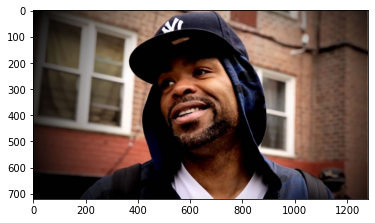

In [15]:
#test의 0번 이미지 출력
img=plt.imread(os.path.join(images,test_images[0]))
plt.imshow(img)
plt.show()

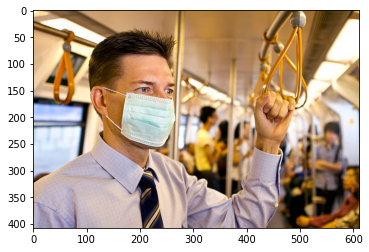

In [16]:
# train의  1번 이미지 출력
img=plt.imread(os.path.join(images,train_images[1]))
plt.imshow(img)
plt.show()

In [16]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)] # 마스크를쓴 경우, 안쓴 경우만 train에 넣은건가?
train.sort_values('name',axis=0,inplace=True) # 이름을 기준으로 정렬

[[112, 113, 262, 307], [127, 194, 243, 293]]


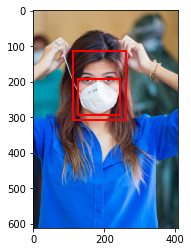

In [18]:
bbox=[] # 왜 두개가 그려지지????
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes: # box 그리기?
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

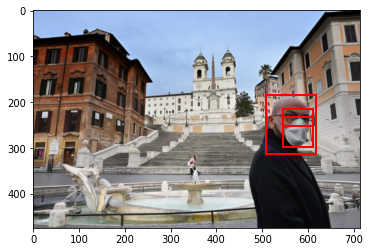

In [19]:
image=train_images[5] # ???? 결과가 많이 이상하다????

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

ValueError: ignored

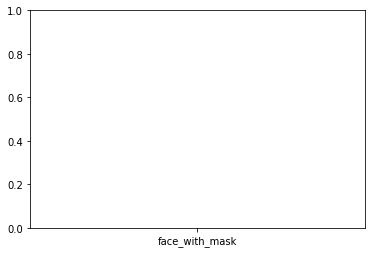

In [21]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts()) # 차트가 안나오는 이유?

In [22]:
img_size=50 # 47분돌다가 오류 발생 ㅜ # 이미지 사이즈 수정 필요?
data=[]
path='/content/drive/MyDrive/mask/Medical mask/Medical Mask/images/'
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()    

error: ignored

https://stackoverflow.com/questions/57265187/error-opencv4-1-0-error-215assertion-failed-ssize-empty-in-function => try문 작성하고 해야하는지?
ㅜㅜㅜㅜㅜ

In [ ]:
data[0][0]
plt.imshow(data[0][0])

In [ ]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [ ]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

## Model Fitting

In [ ]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
model.fit(x,y,epochs=30,batch_size=5)

In [ ]:
detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[0]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

In [ ]:
img=plt.imread(os.path.join(images,test_images[3]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

In [ ]:
detector=MTCNN()
test_df=[]
for image in test_images:
    img=plt.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test=[]
    for face in faces:
        bounding_box=face['box']
        test.append([image,bounding_box])
    test_df.append(test)
test=[]
for i in test_df:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)  
sub=[]
rest_image=[]
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 
detector=MTCNN()
test_df_=[]
for image in rest_image:
    img=cv2.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test_=[]
    for face in faces:
        bounding_box=face['box']
        test_.append([image,bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)    

In [ ]:
negative=[]
for i in test:
    for j in i[1]:
        if j<0:
            negative.append(i)

In [ ]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    test_data.append([j,predict])

create_test_data()  

In [ ]:
image=[]
classname=[]
for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image','classname'])
df['image']=image
df['classname']=classname
df['classname']=lbl.inverse_transform(df['classname'])
image=[]
x1=[]
x2=[]
y1=[]
y2=[]
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name']=image
df['x1']=x1
df['x2']=x2
df['y1']=y1
df['y2']=y2    
df.drop(['image'],axis=1,inplace=True)